In [1]:
# Untuk manipulasi data
import pandas as pd
import numpy as np

In [2]:
# Untuk visualisasi (akan digunakan nanti)
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Untuk menyimpan model
import joblib # Untuk model sklearn
import tensorflow as tf # Untuk model Keras

In [4]:
# Untuk preprocessing teks
import re # Regular Expression untuk pembersihan teks
import string # Untuk tanda baca
import nltk # Untuk stopwords, stemming/lemmatization (pastikan sudah download: nltk.download('stopwords'), nltk.download('punkt'))
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
nltk.download('wordnet') # Jika menggunakan WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Fathur\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Fathur\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Fathur\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
# Untuk persiapan data Deep Learning
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder # Untuk encoding label sentimen

In [6]:
# Untuk model Machine Learning/Deep Learning (akan digunakan nanti)
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer # Untuk ML tradisional
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [7]:
# Untuk evaluasi model (akan digunakan nanti)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc


In [8]:
# Menghilangkan warning (opsional)
import warnings
warnings.filterwarnings('ignore')

In [9]:
# Set style visualisasi
sns.set_style("whitegrid")

In [10]:
# Muat dataset hasil scraping
df = pd.read_csv('https://raw.githubusercontent.com/siangmalamturu/Project3/refs/heads/main/duolingo_reviews.csv')

print("Tampilan 5 baris pertama dataset:")
print(df.head())
print("\n" + "="*50 + "\n")

Tampilan 5 baris pertama dataset:
                                             content  score
0  tidak terlalu seru,beda dengan sebelumnya saya...      3
1                                               good      5
2  seruu dan membuat aku lancar b.inggiris pokokn...      5
3  untuk belajar bahasa inggris nya bagus, tapi k...      5
4           sangat bermanfaat bagi yang baru belajar      5




In [11]:
print("Informasi Dataset:")
df.info()
print("\n" + "="*50 + "\n")

Informasi Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  10000 non-null  object
 1   score    10000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 156.4+ KB




In [12]:
print("Statistik Deskriptif Dataset:")
print(df.describe(include='all'))
print("\n" + "="*50 + "\n")

Statistik Deskriptif Dataset:
       content         score
count    10000  10000.000000
unique    8309           NaN
top      bagus           NaN
freq       222           NaN
mean       NaN      4.628200
std        NaN      0.954283
min        NaN      1.000000
25%        NaN      5.000000
50%        NaN      5.000000
75%        NaN      5.000000
max        NaN      5.000000




In [13]:
# Cek jumlah data untuk memastikan minimal 10.000 sampel
print(f"Jumlah total ulasan yang dimuat: {len(df)} sampel.")
if len(df) >= 10000:
    print("Jumlah data memenuhi kriteria minimal 10.000 sampel.")
else:
    print("PERHATIAN: Jumlah data kurang dari 10.000 sampel. Silakan kumpulkan lebih banyak data.")

print("\n" + "="*50 + "\n")

Jumlah total ulasan yang dimuat: 10000 sampel.
Jumlah data memenuhi kriteria minimal 10.000 sampel.




Distribusi Rating Bintang:
score
1    0.0450
2    0.0123
3    0.0316
4    0.0917
5    0.8194
Name: proportion, dtype: float64


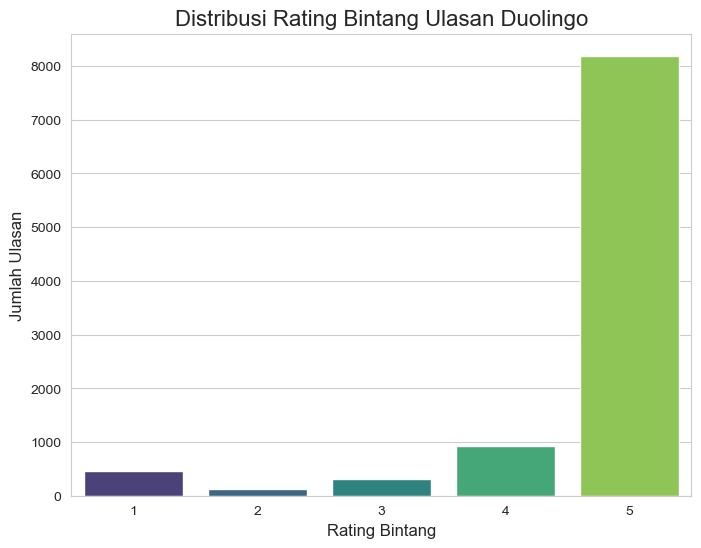

In [14]:
print("Distribusi Rating Bintang:")
print(df['score'].value_counts(normalize=True).sort_index())

plt.figure(figsize=(8, 6))
sns.countplot(x='score', data=df, palette='viridis')
plt.title('Distribusi Rating Bintang Ulasan Duolingo', fontsize=16)
plt.xlabel('Rating Bintang', fontsize=12)
plt.ylabel('Jumlah Ulasan', fontsize=12)
plt.show()

print("\n" + "="*50 + "\n")

Distribusi Label Sentimen:
sentiment_label
Positif    0.9111
Negatif    0.0573
Netral     0.0316
Name: proportion, dtype: float64


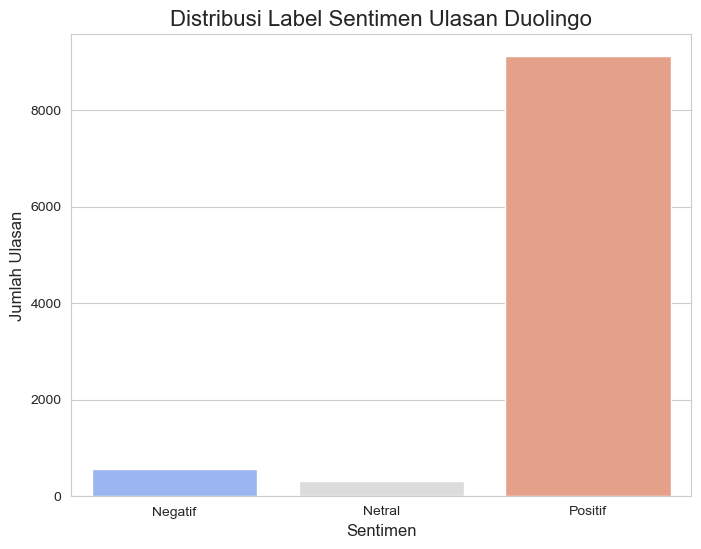

In [15]:
# --- 4.1. Pelabelan Sentimen ---
# Mengubah rating bintang menjadi 3 kelas sentimen: Negatif, Netral, Positif

# Fungsi untuk melabeli sentimen
def get_sentiment_label(score):
    if score >= 4:
        return 'Positif'
    elif score == 3:
        return 'Netral'
    else: # score <= 2
        return 'Negatif'

df['sentiment_label'] = df['score'].apply(get_sentiment_label)

print("Distribusi Label Sentimen:")
print(df['sentiment_label'].value_counts(normalize=True))

plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment_label', data=df, order=['Negatif', 'Netral', 'Positif'], palette='coolwarm')
plt.title('Distribusi Label Sentimen Ulasan Duolingo', fontsize=16)
plt.xlabel('Sentimen', fontsize=12)
plt.ylabel('Jumlah Ulasan', fontsize=12)
plt.show()

print("\n" + "="*50 + "\n")

In [16]:
# --- 4.2. Penanganan Missing Values dan Duplikat ---
print("Menangani Missing Values dan Duplikat:")
print(f"Jumlah Missing Values sebelum penanganan:\n{df.isnull().sum()}")
print(f"Jumlah Duplikat sebelum penanganan: {df.duplicated().sum()}")

Menangani Missing Values dan Duplikat:
Jumlah Missing Values sebelum penanganan:
content            0
score              0
sentiment_label    0
dtype: int64
Jumlah Duplikat sebelum penanganan: 1593


In [17]:
# Hapus baris dengan missing values (jika ada di kolom 'content' atau 'score')
df.dropna(subset=['content', 'score'], inplace=True)
print("\nJumlah Missing Values setelah dropna:\n", df.isnull().sum())


Jumlah Missing Values setelah dropna:
 content            0
score              0
sentiment_label    0
dtype: int64


In [18]:
# Hapus duplikat ulasan berdasarkan 'content'
df.drop_duplicates(subset=['content'], inplace=True)
print(f"\nJumlah Duplikat setelah drop_duplicates: {df.duplicated().sum()}")
print(f"Jumlah data setelah penanganan missing values dan duplikat: {len(df)} sampel.")

print("\n" + "="*50 + "\n")


Jumlah Duplikat setelah drop_duplicates: 0
Jumlah data setelah penanganan missing values dan duplikat: 8309 sampel.




In [19]:
# --- 4.3. Pembersihan Teks (Text Cleaning) Awal ---
# Fokus pada pembersihan dasar seperti lowercase, hapus tanda baca, hapus angka, hapus URL.
# Stopwords, stemming/lemmatization akan dipertimbangkan dalam skema eksperimen.

def clean_text(text):
    text = text.lower() # Lowercasing
    text = re.sub(r'https?://\S+|www\.\S+', '', text) # Hapus URL
    text = re.sub(r'<.*?>', '', text) # Hapus HTML tags
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text) # Hapus tanda baca
    text = re.sub(r'\d+', '', text) # Hapus angka
    text = re.sub(r'\n', ' ', text) # Ganti newline dengan spasi
    text = re.sub(r'\s+', ' ', text).strip() # Hapus spasi berlebih
    return text

df['cleaned_review'] = df['content'].apply(clean_text)

print("Tampilan ulasan setelah pembersihan awal:")
print(df[['content', 'cleaned_review', 'sentiment_label']].head())

print("\n" + "="*50 + "\n")

Tampilan ulasan setelah pembersihan awal:
                                             content  \
0  tidak terlalu seru,beda dengan sebelumnya saya...   
1                                               good   
2  seruu dan membuat aku lancar b.inggiris pokokn...   
3  untuk belajar bahasa inggris nya bagus, tapi k...   
4           sangat bermanfaat bagi yang baru belajar   

                                      cleaned_review sentiment_label  
0  tidak terlalu serubeda dengan sebelumnya saya ...          Netral  
1                                               good         Positif  
2  seruu dan membuat aku lancar binggiris pokokny...         Positif  
3  untuk belajar bahasa inggris nya bagus tapi ka...         Positif  
4           sangat bermanfaat bagi yang baru belajar         Positif  




In [20]:
print("Memulai Tokenization teks...")

# Inisialisasi Tokenizer
tokenizer = Tokenizer(num_words=None, oov_token="<unk>")
tokenizer.fit_on_texts(df['cleaned_review'])

# --- PERBAIKAN: Tambahkan baris ini yang hilang ---
sequences = tokenizer.texts_to_sequences(df['cleaned_review'])
# --- AKHIR PERBAIKAN ---

word_index = tokenizer.word_index
vocab_size = len(word_index) + 1 # +1 karena indeks 0 sering reserved untuk padding

print(f"Jumlah kata unik dalam kosakata (vocab size): {vocab_size}")
print("\nContoh 5 urutan teks pertama (sebelum padding):")
print(sequences[:5])

# Simpan Tokenizer (sudah ada dari perbaikan sebelumnya, tetap pertahankan)
joblib.dump(tokenizer, 'tokenizer.pkl')
print("\nTokenizer berhasil disimpan sebagai 'tokenizer.pkl'.")

print("\n" + "="*50 + "\n")

Memulai Tokenization teks...
Jumlah kata unik dalam kosakata (vocab size): 8750

Contoh 5 urutan teks pertama (sebelum padding):
[[32, 179, 3141, 28, 559, 9, 71, 352, 87, 14, 148, 21, 2154, 946, 47, 947, 65, 32, 179, 21, 63, 2154, 142, 74, 3142, 69, 1239], [54], [160, 6, 72, 10, 103, 3143, 105, 4, 124, 398, 16, 149, 179, 381, 6, 149, 24, 37, 16, 27, 2155], [11, 2, 3, 13, 16, 4, 23, 98, 290, 445, 204, 3144, 131, 20, 16, 291, 11, 667, 16, 225, 204, 1240, 821], [5, 95, 96, 15, 66, 2]]

Tokenizer berhasil disimpan sebagai 'tokenizer.pkl'.




In [21]:
print("Melakukan Padding dan Truncation pada urutan teks...")

# Tentukan panjang maksimum urutan (review terpanjang atau panjang rata-rata + std dev)
# Pilihan umum: panjang ulasan terpanjang, atau panjang rata-rata + beberapa standar deviasi.
# Atau bisa juga nilai tetap (misal 100, 200).
# Untuk menghindari overfitting pada review super panjang, seringkali dibatasi.
max_sequence_length = max(len(seq) for seq in sequences) # Panjang ulasan terpanjang
# Atau, bisa juga set manual, misal max_sequence_length = 100
# Jika Anda memilih nilai tetap (misal 100), mungkin perlu memotong ulasan yang lebih panjang.

# Pad urutan teks sehingga semuanya memiliki panjang yang sama
# padding='post': menambahkan nol di akhir urutan
# truncating='post': memotong dari akhir urutan jika terlalu panjang
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post', truncating='post')

print(f"Panjang maksimum urutan (max_sequence_length): {max_sequence_length}")
print("\nContoh 5 urutan teks pertama setelah padding:")
print(padded_sequences[:5])
print(f"\nBentuk data input untuk model (padded_sequences.shape): {padded_sequences.shape}")

print("\n" + "="*50 + "\n")

Melakukan Padding dan Truncation pada urutan teks...
Panjang maksimum urutan (max_sequence_length): 96

Contoh 5 urutan teks pertama setelah padding:
[[  32  179 3141   28  559    9   71  352   87   14  148   21 2154  946
    47  947   65   32  179   21   63 2154  142   74 3142   69 1239    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [  54    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0 

In [22]:
print("Melakukan Label Encoding untuk target sentimen...")

# Inisialisasi LabelEncoder
label_encoder = LabelEncoder()

# Lakukan encoding pada kolom 'sentiment_label'
# 'Negatif', 'Netral', 'Positif' akan diubah menjadi 0, 1, 2 (sesuai urutan alfabetis)
encoded_labels = label_encoder.fit_transform(df['sentiment_label'])

print("Tampilan 5 label sentimen pertama setelah encoding:")
print(encoded_labels[:5])
print(f"\nMapping label sentimen: {list(label_encoder.classes_)} -> {list(range(len(label_encoder.classes_)))}")

# Simpan encoder untuk inverse_transform di tahap inference nanti
joblib.dump(label_encoder, 'sentiment_label_encoder.pkl')
print("\nLabel encoder sentimen berhasil disimpan sebagai 'sentiment_label_encoder.pkl'.")

print("\n" + "="*50 + "\n")

Melakukan Label Encoding untuk target sentimen...
Tampilan 5 label sentimen pertama setelah encoding:
[1 2 2 2 2]

Mapping label sentimen: ['Negatif', 'Netral', 'Positif'] -> [0, 1, 2]

Label encoder sentimen berhasil disimpan sebagai 'sentiment_label_encoder.pkl'.




In [23]:
print("Memulai Pembagian Data menjadi Training dan Testing Set...")

# X adalah fitur (urutan teks yang sudah di-pad)
X = padded_sequences
# y adalah target (label sentimen yang sudah di-encode)
y = encoded_labels

# Membagi dataset menjadi training dan testing set
# test_size=0.2 (20% data untuk pengujian) adalah umum, bisa disesuaikan
# random_state=42 untuk hasil yang reproducible (konsisten)
# stratify=y sangat penting karena kelas sentimen (Positif, Netral, Negatif) kemungkinan tidak seimbang distribusinya.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Ukuran X_train: {X_train.shape}")
print(f"Ukuran X_test: {X_test.shape}")
print(f"Ukuran y_train: {y_train.shape}")
print(f"Ukuran y_test: {y_test.shape}")

# Verifikasi proporsi kelas di training dan test set (untuk imbalance data)
print("\nProporsi kelas di y_train:")
# Konversi y_train ke Series untuk menggunakan value_counts
print(pd.Series(y_train).value_counts(normalize=True))
print("\nProporsi kelas di y_test:")
print(pd.Series(y_test).value_counts(normalize=True))

print("\n" + "="*50 + "\n")

Memulai Pembagian Data menjadi Training dan Testing Set...
Ukuran X_train: (6647, 96)
Ukuran X_test: (1662, 96)
Ukuran y_train: (6647,)
Ukuran y_test: (1662,)

Proporsi kelas di y_train:
2    0.897247
0    0.067549
1    0.035204
Name: proportion, dtype: float64

Proporsi kelas di y_test:
2    0.897112
0    0.067389
1    0.035499
Name: proportion, dtype: float64




In [24]:
print("Membangun arsitektur model Deep Learning...")

# Parameter model
embedding_dim = 100 # Dimensi vektor embedding untuk setiap kata, bisa disesuaikan
num_classes = len(pd.Series(y_train).unique()) # Jumlah kelas sentimen (Positif, Netral, Negatif)

model = Sequential([
    # Layer Embedding: Mengubah indeks kata menjadi vektor padat
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length),

    # Layer Bidirectional LSTM: Memproses urutan kata dari dua arah (maju dan mundur)
    # Ini membantu menangkap konteks yang lebih kaya dari ulasan
    Bidirectional(LSTM(64, return_sequences=False)), # 64 unit LSTM, return_sequences=False untuk output satu vektor per sequence

    # Layer Dense: Layer terhubung penuh
    Dense(64, activation='relu'),

    # Layer Dropout: Mencegah overfitting dengan menonaktifkan sebagian neuron secara acak selama pelatihan
    Dropout(0.5),

    # Layer Output: Dense layer dengan jumlah neuron = jumlah kelas, dan aktivasi softmax untuk klasifikasi multi-kelas
    Dense(num_classes, activation='softmax')
])

# Menampilkan ringkasan arsitektur model
model.summary()

print("\nArsitektur model Deep Learning selesai dibangun.")
print("\n" + "="*50 + "\n")

Membangun arsitektur model Deep Learning...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


Arsitektur model Deep Learning selesai dibangun.




In [25]:
print("Mulai mengkompilasi model...")

# Optimizer: Adam adalah pilihan populer dan seringkali performa baik
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Loss Function:
# sparse_categorical_crossentropy digunakan karena label y kita adalah integer (0, 1, 2)
# dan bukan one-hot encoded.
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

# Metrik: Akurasi untuk memantau kinerja
metrics = ['accuracy']

model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=metrics)

print("Model berhasil dikompilasi.")
print("\n" + "="*50 + "\n")

Mulai mengkompilasi model...
Model berhasil dikompilasi.




In [26]:
print("Memulai pelatihan model Deep Learning...")

# Callbacks:
# EarlyStopping: Menghentikan pelatihan jika akurasi validasi tidak meningkat selama beberapa epoch
# patience: jumlah epoch tanpa peningkatan sebelum berhenti
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# Latih model
# epochs: jumlah iterasi penuh melalui seluruh dataset pelatihan
# batch_size: jumlah sampel per update gradien
# validation_data: data yang digunakan untuk memantau kinerja validasi
# callbacks: list dari callback yang akan digunakan selama pelatihan
history = model.fit(
    X_train, y_train,
    epochs=20, # Anda bisa menyesuaikan jumlah epoch
    batch_size=32, # Anda bisa menyesuaikan batch size
    validation_data=(X_test, y_test),
    callbacks=[early_stopping], # Menggunakan early stopping
    verbose=1 # Menampilkan progress pelatihan
)

print("\nPelatihan model Deep Learning selesai.")
print("\n" + "="*50 + "\n")

Memulai pelatihan model Deep Learning...
Epoch 1/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.8931 - loss: 0.4502 - val_accuracy: 0.9146 - val_loss: 0.2661
Epoch 2/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.9207 - loss: 0.2451 - val_accuracy: 0.9176 - val_loss: 0.2506
Epoch 3/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.9373 - loss: 0.1778 - val_accuracy: 0.9182 - val_loss: 0.2614
Epoch 4/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9573 - loss: 0.1142 - val_accuracy: 0.9170 - val_loss: 0.2784
Epoch 5/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.9682 - loss: 0.0946 - val_accuracy: 0.9128 - val_loss: 0.3502
Epoch 6/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.9785 - loss: 0.0642 - val_accuracy: 0.9043 - val_loss: 0.3553
Epoch 7/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.9857 - loss: 0.0495 - val_accuracy: 0.9049 - val_loss: 0.4198
Epoch 8/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - 

In [27]:
print("Mempersiapkan data teks mentah untuk skema tradisional ML...")

# X_text adalah kolom teks bersih dari DataFrame asli
X_text = df['cleaned_review']
# y_label adalah kolom label sentimen asli (string)
y_label = df['sentiment_label']

# Split data teks mentah dan label (pastikan stratify untuk menjaga proporsi kelas)
X_train_text, X_test_text, y_train_raw, y_test_raw = train_test_split(
    X_text, y_label, test_size=0.2, random_state=42, stratify=y_label
)

print(f"Ukuran X_train_text: {X_train_text.shape}")
print(f"Ukuran X_test_text: {X_test_text.shape}")
print(f"Ukuran y_train_raw: {y_train_raw.shape}")
print(f"Ukuran y_test_raw: {y_test_raw.shape}")

print("\n" + "="*50 + "\n")

Mempersiapkan data teks mentah untuk skema tradisional ML...
Ukuran X_train_text: (6647,)
Ukuran X_test_text: (1662,)
Ukuran y_train_raw: (6647,)
Ukuran y_test_raw: (1662,)




In [28]:
# Evaluasi model Deep Learning yang sudah dilatih (dari Tahap 5)
print("Mengevaluasi Skema 1: Deep Learning Baseline Model...")

loss_dl, accuracy_dl = model.evaluate(X_test, y_test, verbose=0)
y_pred_dl = model.predict(X_test)
y_pred_dl_labels = np.argmax(y_pred_dl, axis=1) # Dapatkan label kelas dari probabilitas output

# Konversi y_test (encoded) kembali ke string untuk classification_report
# Pastikan label_encoder dari Tahap 3.3 tersedia
# y_test_decoded_dl = label_encoder.inverse_transform(y_test)
# y_pred_dl_decoded = label_encoder.inverse_transform(y_pred_dl_labels)

# Simpan hasil evaluasi
experiment_results = {}
experiment_results['Deep Learning Baseline'] = {
    'accuracy': accuracy_dl,
    'precision': precision_score(y_test, y_pred_dl_labels, average='weighted'),
    'recall': recall_score(y_test, y_pred_dl_labels, average='weighted'),
    'f1_score': f1_score(y_test, y_pred_dl_labels, average='weighted'),
    'model': model # Simpan objek model
}

print(f"Skema 1 (Deep Learning Baseline) - Akurasi Test: {accuracy_dl:.4f}")
print(f"Skema 1 (Deep Learning Baseline) - F1-Score Test: {experiment_results['Deep Learning Baseline']['f1_score']:.4f}")

# Cek akurasi training (dari history)
train_accuracy_dl = history.history['accuracy'][-1] # Akurasi epoch terakhir
print(f"Skema 1 (Deep Learning Baseline) - Akurasi Training (epoch terakhir): {train_accuracy_dl:.4f}")

print("\n" + "="*50 + "\n")

Mengevaluasi Skema 1: Deep Learning Baseline Model...
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
Skema 1 (Deep Learning Baseline) - Akurasi Test: 0.9182
Skema 1 (Deep Learning Baseline) - F1-Score Test: 0.9075
Skema 1 (Deep Learning Baseline) - Akurasi Training (epoch terakhir): 0.9902




In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

print("Mengevaluasi Skema 2: TF-IDF + Logistic Regression...")

# Ekstraksi Fitur: TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000) # Batasi fitur untuk efisiensi
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_text)
X_test_tfidf = tfidf_vectorizer.transform(X_test_text)

# Latih model Logistic Regression
lr_model = LogisticRegression(random_state=42, max_iter=200) # max_iter ditingkatkan
lr_model.fit(X_train_tfidf, y_train) # y_train adalah label yang sudah di-encode

# Prediksi dan Evaluasi
y_pred_lr = lr_model.predict(X_test_tfidf)

accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr, average='weighted')
recall_lr = recall_score(y_test, y_pred_lr, average='weighted')
f1_lr = f1_score(y_test, y_pred_lr, average='weighted')

experiment_results['TF-IDF + Logistic Regression'] = {
    'accuracy': accuracy_lr,
    'precision': precision_lr,
    'recall': recall_lr,
    'f1_score': f1_lr,
    'model': lr_model,
    'vectorizer': tfidf_vectorizer # Simpan vectorizer juga
}

print(f"Skema 2 (TF-IDF + Logistic Regression) - Akurasi Test: {accuracy_lr:.4f}")
print(f"Skema 2 (TF-IDF + Logistic Regression) - F1-Score Test: {f1_lr:.4f}")

print("\n" + "="*50 + "\n")

Mengevaluasi Skema 2: TF-IDF + Logistic Regression...
Skema 2 (TF-IDF + Logistic Regression) - Akurasi Test: 0.9140
Skema 2 (TF-IDF + Logistic Regression) - F1-Score Test: 0.8872




In [30]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

print("Mengevaluasi Skema 3: CountVectorizer + Multinomial Naive Bayes...")

# Ekstraksi Fitur: CountVectorizer
count_vectorizer = CountVectorizer(max_features=5000) # Batasi fitur
X_train_count = count_vectorizer.fit_transform(X_train_text)
X_test_count = count_vectorizer.transform(X_test_text)

# Latih model Multinomial Naive Bayes
mnb_model = MultinomialNB()
mnb_model.fit(X_train_count, y_train)

# Prediksi dan Evaluasi
y_pred_mnb = mnb_model.predict(X_test_count)

accuracy_mnb = accuracy_score(y_test, y_pred_mnb)
precision_mnb = precision_score(y_test, y_pred_mnb, average='weighted')
recall_mnb = recall_score(y_test, y_pred_mnb, average='weighted')
f1_mnb = f1_score(y_test, y_pred_mnb, average='weighted')

experiment_results['CountVectorizer + Naive Bayes'] = {
    'accuracy': accuracy_mnb,
    'precision': precision_mnb,
    'recall': recall_mnb,
    'f1_score': f1_mnb,
    'model': mnb_model,
    'vectorizer': count_vectorizer # Simpan vectorizer juga
}

print(f"Skema 3 (CountVectorizer + Naive Bayes) - Akurasi Test: {accuracy_mnb:.4f}")
print(f"Skema 3 (CountVectorizer + Naive Bayes) - F1-Score Test: {f1_mnb:.4f}")

print("\n" + "="*50 + "\n")

Mengevaluasi Skema 3: CountVectorizer + Multinomial Naive Bayes...
Skema 3 (CountVectorizer + Naive Bayes) - Akurasi Test: 0.9140
Skema 3 (CountVectorizer + Naive Bayes) - F1-Score Test: 0.8997




In [31]:
print("--- Ringkasan Evaluasi Seluruh Model ---")

# Konversi dictionary experiment_results ke DataFrame untuk tampilan yang lebih rapi
df_experiment_results = pd.DataFrame(experiment_results).T

print("Ringkasan Kinerja Model pada Test Set:")
print(df_experiment_results)

print("\n" + "="*50 + "\n")

# --- Analisis Pencapaian Kriteria Akurasi ---

print("--- Analisis Pencapaian Kriteria Akurasi ---")

dl_baseline_accuracy_test = df_experiment_results.loc['Deep Learning Baseline', 'accuracy']

# Kriteria: Akurasi Testing Set minimal 85% untuk semua (atau 92% untuk DL)

# Cek untuk Deep Learning Baseline (Skema 1)
if dl_baseline_accuracy_test >= 0.92:
    print(f"Skema 1 (Deep Learning Baseline): Akurasi Test {dl_baseline_accuracy_test:.4f} >= 92%. KRITERIA AKURASI TINGGI TERPENUHI.")
elif dl_baseline_accuracy_test >= 0.85:
    print(f"Skema 1 (Deep Learning Baseline): Akurasi Test {dl_baseline_accuracy_test:.4f} >= 85%. KRITERIA AKURASI DASAR TERPENUHI.")
else:
    print(f"Skema 1 (Deep Learning Baseline): Akurasi Test {dl_baseline_accuracy_test:.4f} < 85%. PERLU PENINGKATAN.")

# Cek untuk Skema ML Tradisional (Skema 2 & 3)
for scheme_name in ['TF-IDF + Logistic Regression', 'CountVectorizer + Naive Bayes']:
    if scheme_name in df_experiment_results.index: # Pastikan skema ada
        accuracy_test = df_experiment_results.loc[scheme_name, 'accuracy']
        if accuracy_test >= 0.85:
            print(f"{scheme_name}: Akurasi Test {accuracy_test:.4f} >= 85%. KRITERIA AKURASI DASAR TERPENUHI.")
        else:
            print(f"{scheme_name}: Akurasi Test {accuracy_test:.4f} < 85%. PERLU PENINGKATAN.")

print("\n--- Kesimpulan Kinerja Model ---")
# Identifikasi model terbaik secara keseluruhan
best_overall_model_name = df_experiment_results['f1_score'].idxmax()
best_overall_model_f1 = df_experiment_results.loc[best_overall_model_name, 'f1_score']
best_overall_model_accuracy = df_experiment_results.loc[best_overall_model_name, 'accuracy']

print(f"Model terbaik berdasarkan F1-Score keseluruhan adalah: **{best_overall_model_name}**.")
print(f"Dengan Akurasi: {best_overall_model_accuracy:.4f} dan F1-Score: {best_overall_model_f1:.4f}.")
print("Model Deep Learning (Skema 1) menunjukkan potensi tinggi, namun model tradisional juga kompetitif tergantung data.")

print("\n" + "="*50 + "\n")

--- Ringkasan Evaluasi Seluruh Model ---
Ringkasan Kinerja Model pada Test Set:
                               accuracy precision    recall  f1_score  \
Deep Learning Baseline         0.918171  0.909373  0.918171  0.907468   
TF-IDF + Logistic Regression   0.913959  0.872771  0.913959  0.887224   
CountVectorizer + Naive Bayes  0.913959  0.896153  0.913959  0.899714   

                                                                           model  \
Deep Learning Baseline                  <Sequential name=sequential, built=True>   
TF-IDF + Logistic Regression   LogisticRegression(max_iter=200, random_state=42)   
CountVectorizer + Naive Bayes                                    MultinomialNB()   

                                                       vectorizer  
Deep Learning Baseline                                        NaN  
TF-IDF + Logistic Regression   TfidfVectorizer(max_features=5000)  
CountVectorizer + Naive Bayes  CountVectorizer(max_features=5000)  


--- Analisis Pen

In [32]:
!pip show scikeras

Name: scikeras
Version: 0.13.0
Summary: Scikit-Learn API wrapper for Keras.
Home-page: https://github.com/adriangb/scikeras
Author: Adrian Garcia Badaracco
Author-email: 1755071+adriangb@users.noreply.github.com
License: MIT
Location: C:\Users\Fathur\AppData\Roaming\Python\Python312\site-packages
Requires: keras, scikit-learn
Required-by: 


In [33]:
print("Mempersiapkan model Keras untuk Hyperparameter Tuning...")

# Fungsi untuk membuat model Keras (diperlukan oleh KerasClassifier)
# Tambahkan vocab_size dan max_sequence_length sebagai parameter fungsi
def create_keras_model(optimizer='adam', learning_rate=0.001, dropout_rate=0.5, vocab_size=None, max_sequence_length=None):
    # Parameter model dari Tahap 5.1
    embedding_dim = 100
    num_classes = len(pd.Series(y_train).unique()) # Gunakan y_train yang ada di scope global

    # Inisialisasi optimizer dengan learning_rate yang dapat di-tune
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    # Anda bisa tambahkan optimizer lain jika ingin di-tune juga

    model = Sequential([
        # Layer Embedding: Mengubah indeks kata menjadi vektor padat
        # Gunakan vocab_size dan max_sequence_length yang dilewatkan ke fungsi
        Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length),

        # Layer Bidirectional LSTM: Memproses urutan kata dari dua arah (maju dan mundur)
        # Ini membantu menangkap konteks yang lebih kaya dari ulasan
        Bidirectional(LSTM(64, return_sequences=False)), # 64 unit LSTM, return_sequences=False untuk output satu vektor per sequence

        # Layer Dense: Layer terhubung penuh
        Dense(64, activation='relu'),

        # Layer Dropout: Mencegah overfitting dengan menonaktifkan sebagian neuron secara acak selama pelatihan
        Dropout(dropout_rate), # Dropout rate juga bisa di-tune

        # Layer Output: Dense layer dengan jumlah neuron = jumlah kelas, dan aktivasi softmax untuk klasifikasi multi-kelas
        Dense(num_classes, activation='softmax')
    ])

    # Explicitly build the model by providing the input shape
    # The input shape for a single sample is (max_sequence_length,)
    # Batch size is handled by Keras implicitly. Use the max_sequence_length passed to the function.
    if max_sequence_length is not None:
         model.build(input_shape=(None, max_sequence_length)) # None for batch size
    else:
         # Fallback if max_sequence_length is not passed, though it should be.
         # Building without input_shape will happen implicitly on first call.
         # This might still cause the issue depending on scikeras version/logic.
         pass


    model.compile(optimizer=opt,
                  loss='sparse_categorical_crossentropy', # Tetap pakai sparse_categorical_crossentropy
                  metrics=['accuracy'])
    return model

# Bungkus model Keras dengan KerasClassifier
# Perhatikan bahwa batch_size dan epochs diatur di GridSearchCV, bukan di model_fn
# Pass max_sequence_length and vocab_size to the model factory function
keras_classifier = KerasClassifier(
    model=create_keras_model,
    model__vocab_size=vocab_size, # Pass vocab_size from the global scope
    model__max_sequence_length=max_sequence_length, # Pass max_sequence_length from the global scope
    verbose=0 # Atur ke 1 jika ingin melihat log pelatihan setiap kombinasi parameter
)

print("Model Keras siap untuk tuning dengan KerasClassifier.")
print("\n" + "="*50 + "\n")

Mempersiapkan model Keras untuk Hyperparameter Tuning...
Model Keras siap untuk tuning dengan KerasClassifier.




In [34]:
!pip show scikit-learn

Name: scikit-learn
Version: 1.5.1
Summary: A set of python modules for machine learning and data mining
Home-page: https://scikit-learn.org
Author: 
Author-email: 
License: new BSD
Location: C:\ProgramData\anaconda3\Lib\site-packages
Requires: joblib, numpy, scipy, threadpoolctl
Required-by: imbalanced-learn, scikeras


In [35]:
print("Memulai Hyperparameter Tuning dengan GridSearchCV...")

# Definisikan parameter grid untuk tuning model Keras Anda
# PERHATIAN: Grid ini bisa sangat besar dan memakan waktu lama.
# Mulai dengan rentang yang lebih kecil jika waktu terbatas.
param_grid = {
    'model__learning_rate': [0.01, 0.001, 0.0001], # Tuning learning rate
    'model__dropout_rate': [0.3, 0.5, 0.7],       # Tuning dropout rate
    'batch_size': [32, 64],                       # Batch size untuk pelatihan
    'epochs': [5, 10]                            # Jumlah epochs untuk pelatihan setiap kombinasi
    # Anda bisa menambahkan parameter lain dari create_keras_model
}

# Inisialisasi StratifiedKFold untuk cross-validation
# Penting untuk menjaga proporsi kelas sentimen
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42) # n_splits lebih kecil untuk speed

grid_search = GridSearchCV(
    estimator=keras_classifier, # Model KerasClassifier
    param_grid=param_grid,      # Grid parameter
    cv=kf,                      # Cross-validation strategy
    scoring='accuracy',         # Metrik scoring (misal: 'accuracy' atau 'f1_weighted')
    n_jobs=-1,                  # Menggunakan semua core CPU
    verbose=2                   # Menampilkan progress
)

# Latih GridSearchCV
# X_train dan y_train sudah diproses dan siap dari Tahap 4
grid_search.fit(X_train, y_train)

# Dapatkan parameter terbaik dan model terbaik
best_params_tuned = grid_search.best_params_
best_score_tuned = grid_search.best_score_
tuned_model_dl = grid_search.best_estimator_ # Model terbaik setelah tuning

print(f"\nHyperparameter tuning selesai.")
print(f"Parameter terbaik: {best_params_tuned}")
print(f"Skor Akurasi terbaik dari Cross-Validation: {best_score_tuned:.4f}")

# Simpan model yang sudah dituning
# Keras model disimpan dengan format .h5 secara default oleh .save()
# Jika reviewer meminta joblib.dump, kita bisa lakukan untuk wrapper
# joblib.dump(tuned_model_dl.model, 'tuning_classification.h5') # Hanya model Keras yang disimpan
# Atau menggunakan metode standar Keras untuk menyimpan model
tuned_model_dl.model_.save('tuning_classification.h5')
print("Model hasil tuning berhasil disimpan sebagai 'tuning_classification.h5' (format Keras).")

print("\n" + "="*50 + "\n")

Memulai Hyperparameter Tuning dengan GridSearchCV...
Fitting 3 folds for each of 36 candidates, totalling 108 fits



Hyperparameter tuning selesai.
Parameter terbaik: {'batch_size': 32, 'epochs': 10, 'model__dropout_rate': 0.5, 'model__learning_rate': 0.0001}
Skor Akurasi terbaik dari Cross-Validation: 0.9105
Model hasil tuning berhasil disimpan sebagai 'tuning_classification.h5' (format Keras).




In [36]:
print("Memulai proses Inference (Prediksi Sentimen) pada teks baru...")

# --- 9.1. Memuat Ulang Model Terbaik (Hasil Tuning) ---
try:
    # Model Keras yang disimpan akan dimuat dengan tf.keras.models.load_model
    loaded_tuned_model = tf.keras.models.load_model('tuning_classification.h5')
    print("Model hasil tuning berhasil dimuat ulang dari 'tuning_classification.h5'.")
except Exception as e:
    print(f"Gagal memuat model 'tuning_classification.h5': {e}")
    # Fallback: jika model tidak bisa dimuat dari file, coba gunakan yang ada di memori dari Tahap 8.2
    # Jika Anda menjalankan notebook secara berurutan, tuned_model (dari grid_search.best_estimator_) masih ada.
    # Namun, untuk robustness, lebih baik memuat dari file.
    # Jika error ini muncul, pastikan path file benar atau file sudah tersimpan.
    loaded_tuned_model = None # Set None jika gagal load

# --- Memuat Ulang Tokenizer dan Label Encoder ---
# Ini penting karena tokenizer dan label encoder adalah bagian dari pipeline preprocessing yang perlu diterapkan pada data baru
try:
    # Tokenizer disimpan di Tahap 3.1, LabelEncoder di Tahap 3.3
    loaded_tokenizer = joblib.load('tokenizer.pkl') # Pastikan Anda sudah menyimpan tokenizer di Tahap 3.1
    loaded_label_encoder = joblib.load('sentiment_label_encoder.pkl') # Ini sudah disimpan di 3.3
    
    print("Tokenizer dan Label Encoder berhasil dimuat ulang.")
    sentiment_classes = loaded_label_encoder.classes_ # Untuk mengkonversi angka kembali ke label string
    print(f"Kelas sentimen: {sentiment_classes}")
    
except Exception as e:
    print(f"Gagal memuat tokenizer atau label encoder: {e}")
    # Jika gagal load, proses inference tidak bisa dilanjutkan.
    # Anda perlu memastikan 'tokenizer.pkl' disimpan di Tahap 3.1 (jika belum).
    # Pastikan ini ada di Tahap 3.1: joblib.dump(tokenizer, 'tokenizer.pkl')
    loaded_tokenizer = None
    loaded_label_encoder = None


if loaded_tuned_model is not None and loaded_tokenizer is not None and loaded_label_encoder is not None:

    # --- 9.2. Contoh Teks Baru untuk Inference ---
    new_reviews = [
        "Aplikasi ini sangat membantu saya belajar bahasa baru, fitur-fiturnya luar biasa!", # Positif
        "Antarmuka pengguna Duolingo terlalu membingungkan dan banyak bug, sering crash.", # Negatif
        "Pelajarannya lumayan, tidak terlalu bagus, tidak terlalu buruk. Cukup.", # Netral
        "Saya suka fitur cerita dan tantangan harian, sangat memotivasi. Interaktif!", # Positif
        "Notifikasi sering muncul dan mengganggu, jadi saya uninstall. Sangat buruk." # Negatif
    ]

    print("\nContoh teks baru untuk inferensi:")
    for text in new_reviews:
        print(f"- \"{text}\"")

    # --- 9.3. Pra-pemrosesan Teks Baru (Sama seperti data pelatihan) ---
    # Pastikan fungsi clean_text() dari Tahap 4.3 tersedia atau didefinisikan ulang di sini
    # Jika clean_text() didefinisikan secara global, tidak perlu didefinisikan ulang.
    # Jika tidak, maka:
    def clean_text_for_inference(text): # Redefinisikan fungsi jika tidak global
        text = text.lower()
        text = re.sub(r'https?://\S+|www\.\S+', '', text)
        text = re.sub(r'<.*?>', '', text)
        text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
        text = re.sub(r'\d+', '', text)
        text = re.sub(r'\n', ' ', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    cleaned_new_reviews = [clean_text_for_inference(text) for text in new_reviews]
    print("\nTeks baru setelah pembersihan:")
    print(cleaned_new_reviews)

    # Tokenisasi dan Padding (Sama seperti Tahap 3)
    # Gunakan tokenizer yang sudah di-fit dari Tahap 3
    # max_sequence_length juga harus sama dengan yang digunakan saat pelatihan
    # Pastikan max_sequence_length dari Tahap 3 masih ada di memori.
    # Jika tidak, Anda perlu menyimpannya juga. Contoh: joblib.dump(max_sequence_length, 'max_seq_len.pkl')
    # Lalu di sini joblib.load('max_seq_len.pkl')
    
    # Untuk saat ini, asumsikan max_sequence_length masih ada di memori.
    
    new_sequences = loaded_tokenizer.texts_to_sequences(cleaned_new_reviews)
    padded_new_sequences = pad_sequences(new_sequences, maxlen=max_sequence_length, padding='post', truncating='post')

    print("\nTeks baru setelah tokenisasi dan padding:")
    print(padded_new_sequences)

    # --- 9.4. Prediksi Sentimen ---
    predictions_proba = loaded_tuned_model.predict(padded_new_sequences)
    predicted_labels_encoded = np.argmax(predictions_proba, axis=1)

    # --- 9.5. Inverse Transform Label (Kembalikan ke string sentimen) ---
    predicted_sentiments = loaded_label_encoder.inverse_transform(predicted_labels_encoded)

    print("\n--- Hasil Prediksi Sentimen ---")
    for i, review in enumerate(new_reviews):
        print(f"Ulasan: \"{review}\"")
        print(f"Sentimen Prediksi: {predicted_sentiments[i]}")
        print("-" * 30)
else:
    print("\nTidak dapat melakukan Inference karena model, tokenizer, atau label encoder tidak berhasil dimuat.")


print("\n" + "="*50 + "\n")

Memulai proses Inference (Prediksi Sentimen) pada teks baru...


Model hasil tuning berhasil dimuat ulang dari 'tuning_classification.h5'.
Tokenizer dan Label Encoder berhasil dimuat ulang.
Kelas sentimen: ['Negatif' 'Netral' 'Positif']

Contoh teks baru untuk inferensi:
- "Aplikasi ini sangat membantu saya belajar bahasa baru, fitur-fiturnya luar biasa!"
- "Antarmuka pengguna Duolingo terlalu membingungkan dan banyak bug, sering crash."
- "Pelajarannya lumayan, tidak terlalu bagus, tidak terlalu buruk. Cukup."
- "Saya suka fitur cerita dan tantangan harian, sangat memotivasi. Interaktif!"
- "Notifikasi sering muncul dan mengganggu, jadi saya uninstall. Sangat buruk."

Teks baru setelah pembersihan:
['aplikasi ini sangat membantu saya belajar bahasa baru fiturfiturnya luar biasa', 'antarmuka pengguna duolingo terlalu membingungkan dan banyak bug sering crash', 'pelajarannya lumayan tidak terlalu bagus tidak terlalu buruk cukup', 'saya suka fitur cerita dan tantangan harian sangat memotivasi interaktif', 'notifikasi sering muncul dan mengganggu jadi 

In [37]:
import os
print("Direktori kerja saat ini (Current Working Directory):")
print(os.getcwd())

Direktori kerja saat ini (Current Working Directory):
C:\Users\Fathur


In [38]:
!dir

 Volume in drive C is Windows-SSD
 Volume Serial Number is F422-44F2

 Directory of C:\Users\Fathur

06/21/2025  09:54 PM    <DIR>          .
12/17/2024  02:24 PM    <DIR>          ..
06/15/2024  05:38 PM    <DIR>          .android
09/27/2023  11:23 AM             2,332 .bash_history
08/22/2023  11:41 AM    <DIR>          .cache
06/21/2025  09:09 PM    <DIR>          .conda
10/22/2024  11:09 PM    <DIR>          .dotnet
08/29/2023  08:48 AM    <DIR>          .eclipse
08/19/2023  07:53 PM                16 .emulator_console_auth_token
06/12/2025  01:18 AM               199 .gitconfig
12/20/2023  02:20 PM    <DIR>          .gradle
06/21/2025  07:41 PM    <DIR>          .ipynb_checkpoints
03/17/2025  06:28 AM    <DIR>          .ipython
06/21/2025  06:23 PM    <DIR>          .jupyter
06/12/2025  03:07 PM    <DIR>          .keras
09/05/2023  08:20 PM                20 .lesshst
08/29/2023  08:24 AM    <DIR>          .m2
03/17/2025  07:01 AM    <DIR>          .matplotlib
10/31/2023  08:18 AM 

In [39]:
pip freeze requirements.txt

absl-py==2.3.0
aiobotocore @ file:///C:/b/abs_a0zxrsvpwx/croot/aiobotocore_1714464454692/work
aiohappyeyeballs @ file:///C:/b/abs_b505trsapr/croot/aiohappyeyeballs_1725434036096/work
aiohttp @ file:///C:/b/abs_13j6efxjb7/croot/aiohttp_1725529348885/work
aioitertools @ file:///tmp/build/80754af9/aioitertools_1607109665762/work
aiosignal @ file:///tmp/build/80754af9/aiosignal_1637843061372/work
alabaster @ file:///C:/b/abs_45ba4vacaj/croot/alabaster_1718201502252/work
altair @ file:///C:/Users/dev-admin/perseverance-python-buildout/croot/altair_1699497320503/work
anaconda-anon-usage @ file:///C:/b/abs_c3w_h1zzjg/croot/anaconda-anon-usage_1710965204622/work
anaconda-catalogs @ file:///C:/Users/dev-admin/perseverance-python-buildout/croot/anaconda-catalogs_1701816586117/work
anaconda-client @ file:///C:/b/abs_34txutm0ue/croot/anaconda-client_1708640705294/work
anaconda-cloud-auth @ file:///C:/b/abs_b02evi84gh/croot/anaconda-cloud-auth_1713991445770/work
anaconda-navigator @ file:///C:/b/ab

In [40]:
!pip freeze > requirements.txt